![Logo](assets/logo.png)

Made by **Domonkos Nagy**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/8.%20Function%20Approximation/tile_coding.ipynb)

# Tile Coding

Tile coding is a simple function approximation method, that involves splitting a continuous space to a finite number of regions.
The simplest form of tile coding would be state aggregation: the left side of the figure below shows
a 2-dimensional space partitioned into 16 distinct regions. A partitioning like this is called a *tiling*, and each partition
of a tiling is called a *tile*: each tile has some value associated with it, wich can be learned.
If just this single tiling were used, then the
state indicated by the white spot would be represented by the single feature whose tile
it falls within; generalization would be complete to all states within the same tile and
nonexistent to states outside it.

![Tile coding example](assets/tile_coding.png)

*Figure from Sutton & Barto, pg. 217*

To achieve better generalization, we can use multiple different tilings: the right side of the figure below shows the same space
with 4 tilings, each of them offset by a small amount. To approximate some function at any point in the space, the values
of the tiles that the point falls inside are simply added up.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
%config InlineBackend.print_figure_kwargs = {'pad_inches': .3}

In [2]:
# Domain boundaries
LOW = 0
HIGH = 6

In [3]:
# The function to approximate
def target(x, y):
    return np.sin(x) + np.cos(y)

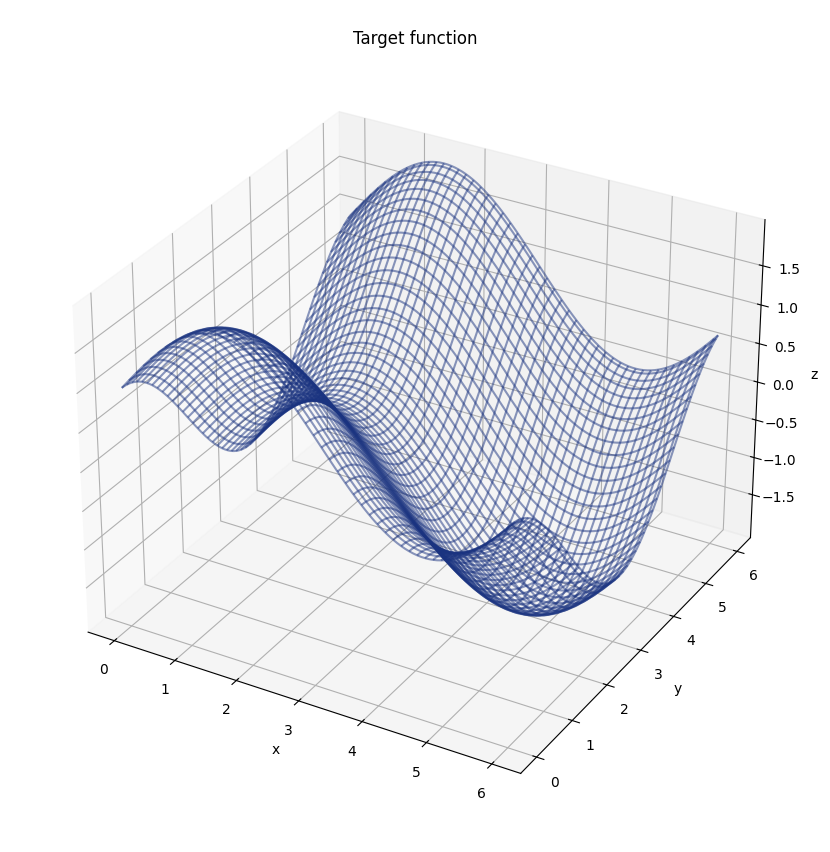

In [4]:
# Plot function surface
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x, y = (np.linspace(LOW, HIGH, 100) for _ in range(2))
x, y = np.meshgrid(x, y)
z = target(x, y)
true_surface = ax.plot_wireframe(x, y, z, color=(0.1, 0.2, 0.5, 0.5))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Target function')
plt.show()

In [5]:
class TiledQTable:
    def __init__(self, offsets, n_bins):
        self.tilings = []
        self.n_tilings = len(offsets)
        n_dims = len(offsets[0])

        # Create tilings
        for offset in offsets:
            tiling = [np.linspace(LOW, HIGH, n_bins + 1)[1:-1] + offset[dim] for dim in range(n_dims)]
            self.tilings.append(tiling)

        # Initialize q-table
        shape = (self.n_tilings, ) + (n_bins, ) * n_dims
        self.q_table = np.zeros(shape)

    def __getitem__(self, coords):
        val = 0

        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(coords)):
                ind.append(np.searchsorted(tiling[dim], coords[dim]))
            val += self.q_table[tuple(ind)]

        return val

    def __setitem__(self, coords, new):
        old = self.__getitem__(coords)

        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(coords)):
                ind.append(np.searchsorted(tiling[dim], coords[dim]))
            self.q_table[tuple(ind)] += (new - old) / self.n_tilings

    def __call__(self, *args):
        shape = args[0].shape
        z = np.zeros(shape)

        for i in np.ndindex(shape):
            x = [arg[i] for arg in args]
            z[i] = self.__getitem__(x)

        return z

In [6]:
# Hyperparameters
N_TILINGS = 4  # number of tilings
N_BINS = 12  # number of bins per dimension per tiling
N_STEPS = 100_000  # number of learning steps
ALPHA = 0.1  # learning rate
NOISE = 0.1  # variance of the target

In [7]:
# Set asymmetrical offsets to avoid artifacts in
# generalization; see Sutton & Barto pg. 218-220 for details
tile_width = (HIGH - LOW) / N_BINS
unit = tile_width / N_TILINGS
offsets = [(unit * i, 3 * unit * i) for i in range(N_TILINGS)]

# Initialize tiled q-table
tqt = TiledQTable(offsets, N_BINS)

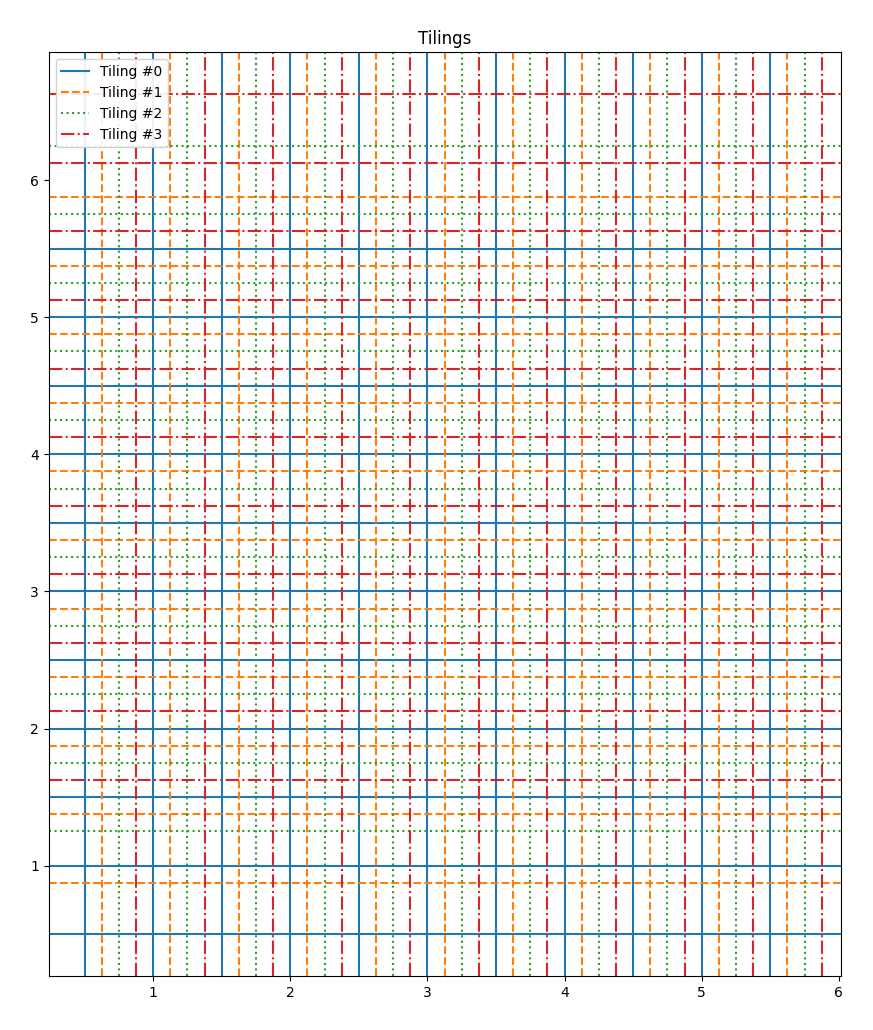

In [8]:
# Visualize tilings
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', ':', '-.']
legend_lines = []

fig, ax = plt.subplots(figsize=(12, 12))
for i, grid in enumerate(tqt.tilings):
    for x in grid[0]:
        line = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
    for y in grid[1]:
        line = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
    legend_lines.append(line)

ax.legend(legend_lines, [f"Tiling #{t}" for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
ax.set_title("Tilings")
ax.set_aspect('equal', adjustable='box')

plt.show()

In [9]:
# Learning
for _ in trange(N_STEPS):
    x, y = np.random.rand(2) * (HIGH - LOW) + LOW
    z = target(x, y) + np.random.normal(0, NOISE)  # Target function value + Gaussian noise
    tqt[x, y] += ALPHA * (z - tqt[x, y])

  0%|          | 0/100000 [00:00<?, ?it/s]

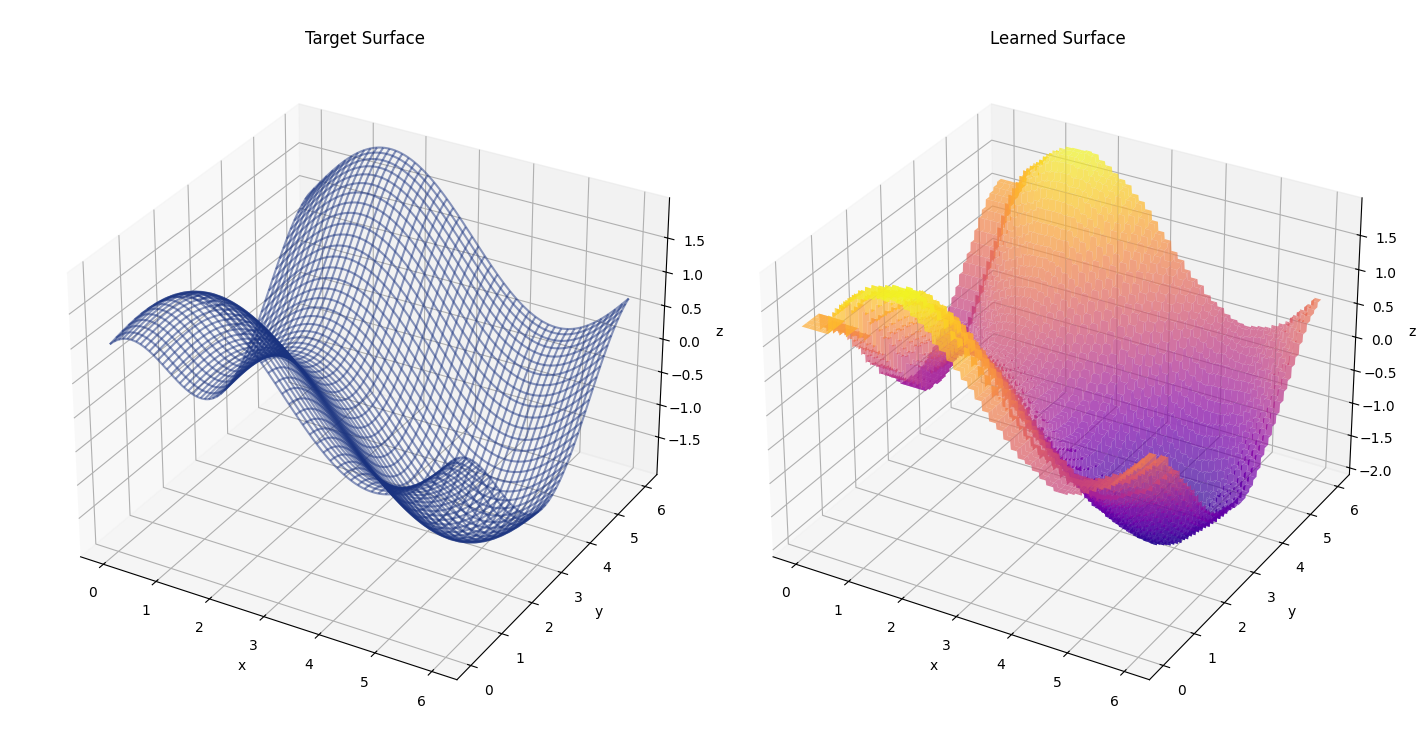

In [10]:
# Calculating target & learned values on the domain
x, y = (np.linspace(LOW, HIGH, (HIGH - LOW) * 100) for _ in range(2))
x, y = np.meshgrid(x, y)
z = target(x, y)
z_learned = tqt(x, y)

# Plotting target surface
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121, projection='3d')
true_surface = ax.plot_wireframe(x, y, z,
                                 color=(0.1, 0.2, 0.5, 0.5),
                                 label='True values')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Target Surface')

# Plotting learned surface
ax = fig.add_subplot(122, projection='3d')
learned_surface = ax.plot_surface(x, y, z_learned, cmap='plasma',
                                  alpha=.7, label='Learned values')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Learned Surface')

plt.tight_layout()
plt.show()